In [1]:
import torch
from torchdiffeq import odeint
from tqdm import tqdm
T = 1
true_x0 = torch.tensor([0.]).unsqueeze(0)
t = torch.linspace(0., T, 100)
target_x = torch.tensor([-1]).unsqueeze(0)

In [2]:
class TallNN(torch.nn.Module):
    def __init__(self, max_active_neurons=1000, n_layers=10):
        super().__init__()
        neurons_per_layer = int(max_active_neurons//n_layers)
        input_layer = [torch.nn.Linear(1, neurons_per_layer, 
                                       bias=False), torch.nn.Tanh()]
        intermediate_layers = [
            torch.nn.Linear(neurons_per_layer, 
                            neurons_per_layer, bias=False),
            torch.nn.Tanh()
        ]*n_layers
        
        output_layer = [torch.nn.Linear(neurons_per_layer,1,
                                        bias=False)]
        
        self.nn = torch.nn.Sequential(
            *(input_layer+intermediate_layers+output_layer)
        )

        
        
    def forward(self, t, x):
        tt = torch.as_tensor(t).unsqueeze(0)
        dx = self.nn(tt)
        return dx


In [3]:
n_neurons = list(range(100, 1200, 100))
n_layers = list(range(1, 10))

In [4]:

results = []
for n_lay in tqdm(n_layers):
    for n_neu in tqdm(n_neurons):
        wnn = TallNN(n_neu, n_lay)
        opt = torch.optim.Adam(wnn.parameters(), lr=0.001)
        loss_v = 1
        rerr = 100
        j = 0
        #while loss_v > 10e-8 or rerr > 10e-9:
        while j < 100:
            opt.zero_grad()
            x = odeint(wnn, true_x0, t)
            loss = ((x[-1, :, :] - target_x)**2).mean()
            loss.backward()
            rerr = abs(loss_v - loss.item())
            loss_v = loss.item()
            opt.step()
            j+=1
            
        u =wnn(t.unsqueeze(-1), None) 
        #TODO: divide by 2 here
        energy = (((u)**2)*0.01).sum().item()
        results.append(dict(n_neurons=n_neu,
                            n_layers = n_lay,
                            energy=energy, 
                            loss=loss_v,
                            mean_control = u.mean().item(),
                            mean_variance = u.var().item()
                            )
                      )

  0%|          | 0/11 [00:00<?, ?it/s]/home/ta/miniconda3/envs/numdyn/lib/python3.8/site-packages/torch/autograd/__init__.py:154: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811806235/work/c10/cuda/CUDAFunctions.cpp:112.)
  Variable._execution_engine.run_backward(

100%|██████████| 9/9 [09:04<00:00, 60.47s/it]


In [17]:
with torch.no_grad():
    x = odeint(lambda t,x: -torch.ones([1]), true_x0, t)
    loss = ((x[-1, :, :] - target_x)**2)
loss

tensor([[1.4211e-14]])

In [18]:
baseline_energy = (((-torch.ones_like(u))**2*0.01)).sum()
baseline_energy

tensor(1.)

In [19]:
import pandas as pd
df = pd.DataFrame(results)

In [20]:
df.to_csv('heatmap.csv')

In [21]:
import plotly.express as px

In [22]:
df

n_neurons  n_layers    energy          loss  mean_control  mean_variance
0         100         1  1.282813  9.707467e-07     -1.000736       0.284184
1         200         1  1.263910  1.814052e-05     -0.994661       0.277333
2         300         1  1.264420  1.446247e-05     -0.995748       0.275662
3         400         1  1.261923  5.619443e-06     -0.995144       0.274355
4         500         1  1.258221  1.072196e-05     -0.994778       0.271350
..        ...       ...       ...           ...           ...            ...
94        700         9  1.081334  2.792096e-06     -0.996176       0.089865
95        800         9  1.095998  2.160584e-05     -1.000675       0.095605
96        900         9  1.112237  2.430355e-06     -0.997454       0.118509
97       1000         9  1.067241  9.234087e-06     -0.999629       0.068670
98       1100         9  1.055900  1.122423e-05     -0.993137       0.070283

[99 rows x 6 columns]

In [23]:
hm = df.pivot(index='n_neurons', 
              columns='n_layers', 
              values='energy')
hm2 = df.pivot(index='n_neurons', 
              columns='n_layers', 
               values='loss')
hm3 = df.pivot(index='n_neurons', 
              columns='n_layers', 
               values='mean_control')
hm4 = df.pivot(index='n_neurons', 
              columns='n_layers', 
               values='mean_variance')

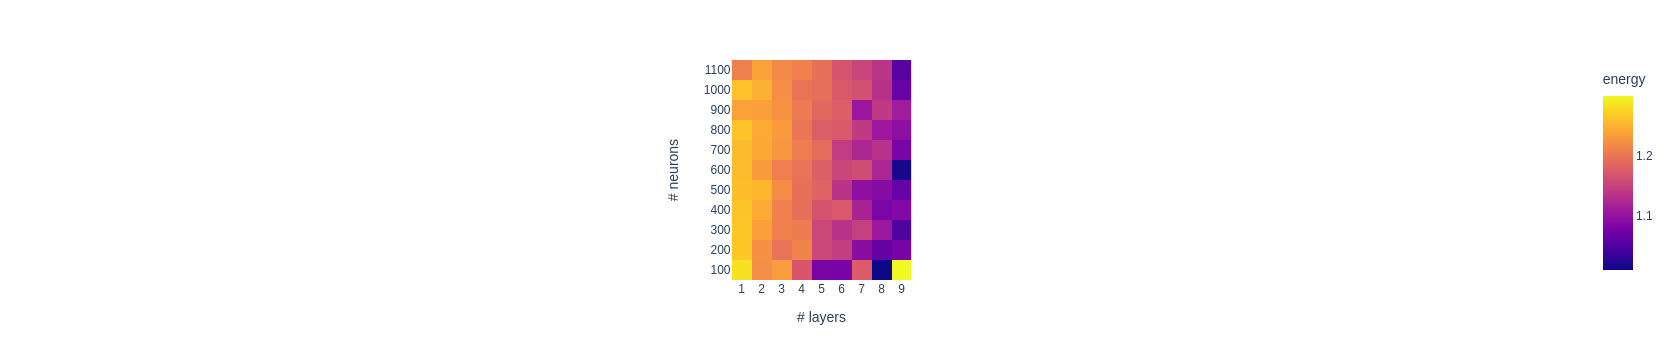

In [24]:
f = px.imshow(hm.values, 
          y=hm.index.map(str), 
          x=hm.columns.map(str),
          labels = {'x' : '# layers',
                    'y' : '# neurons',
                    'color' : 'energy'

                   },
          origin = 'lower'
         )

f

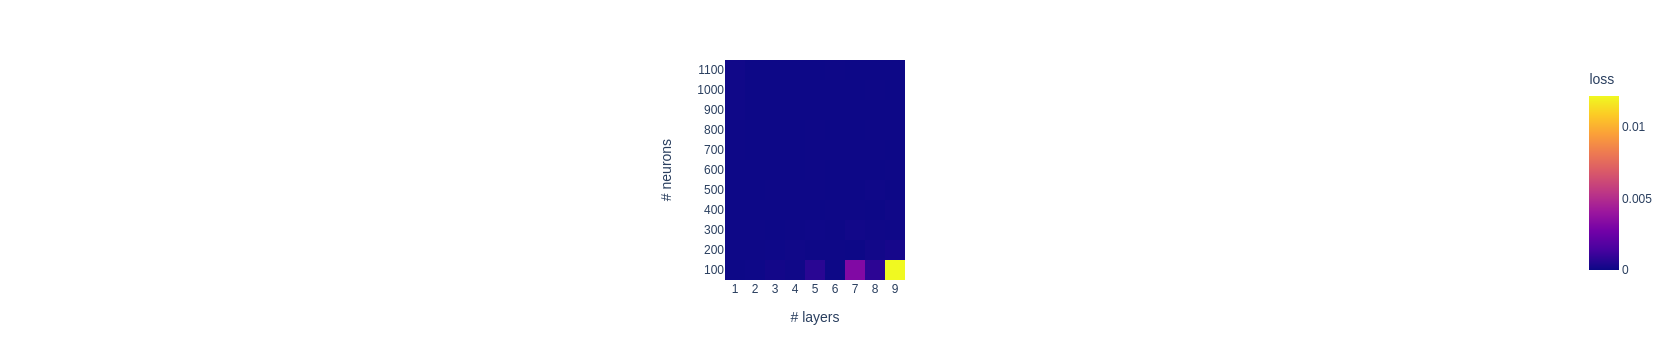

In [25]:
f = px.imshow(hm2.values, 
          y=hm2.index.map(str), 
          x=hm2.columns.map(str),
          labels = {'x' : '# layers',
                    'y' : '# neurons',
                     'color' : 'loss'
                   },
          origin = 'lower',
         )
f

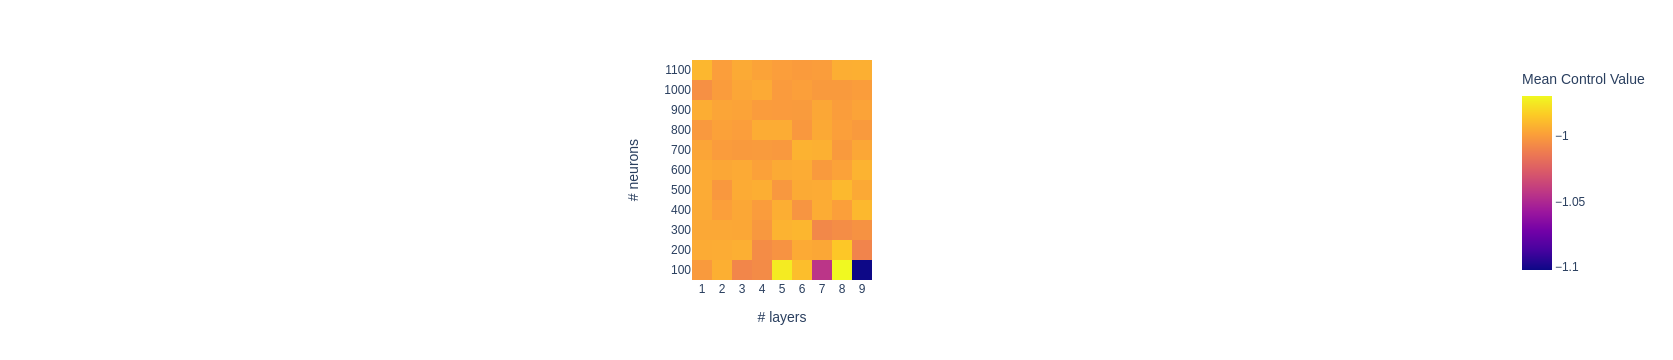

In [26]:
f = px.imshow(hm3.values, 
          y=hm3.index.map(str), 
          x=hm3.columns.map(str),
          labels = {'x' : '# layers',
                    'y' : '# neurons',
                     'color' : 'Mean Control Value'
                   },
          origin = 'lower',
         )
f

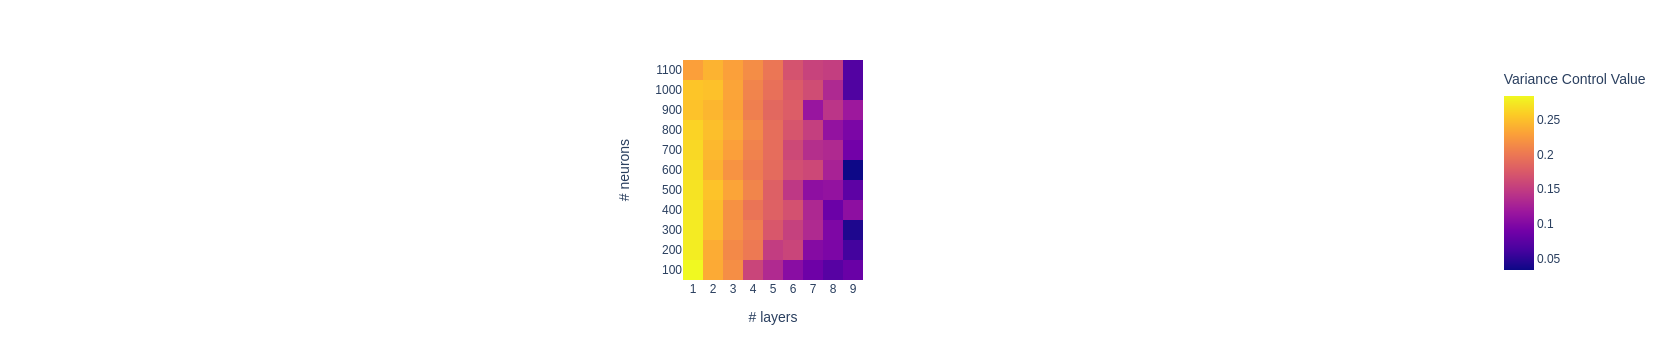

In [27]:
f = px.imshow(hm4.values, 
          y=hm4.index.map(str), 
          x=hm4.columns.map(str),
          labels = {'x' : '# layers',
                    'y' : '# neurons',
                     'color' : 'Variance Control Value'
                   },
          origin = 'lower',
         )
f.write_html('var_control_heat.html')
f

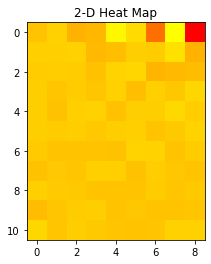

In [16]:
import matplotlib.pyplot as plt
  
plt.imshow( hm3 , cmap = 'autumn' , interpolation = 'nearest' )
  
plt.title( "2-D Heat Map" )
plt.show()